<a href="https://colab.research.google.com/github/rahiraja22/final_face_prediction_project/blob/main/YOLO8v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd


# Load bounding box CSV
df = pd.read_csv('faces.csv')

# Show first 5 rows
print(df.head())
print("Total rows:", len(df))

     image_name  width  height   x0   y0    x1   y1
0  00001722.jpg   1333    2000  490  320   687  664
1  00001044.jpg   2000    1333  791  119  1200  436
2  00001050.jpg    667    1000  304  155   407  331
3  00001736.jpg    626     417  147   14   519  303
4  00003121.jpg    626     418  462   60   599  166
Total rows: 3350


In [ ]:
import zipfile

zip_path = "images-20250718T053658Z-1-001.zip"
extract_path = "/content/image/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted successfully!")

✅ Extracted successfully!


In [ ]:
import os

image_dir = '/content/image/images/'
files = os.listdir(image_dir)
print(files[:5])

['00003017.jpg', '00001983.jpg', '00000353.jpg', '00002634.jpg', '00002276.jpg']


In [ ]:
import pandas as pd
import os

# Load CSV
df = pd.read_csv("/content/faces.csv")

# Remove duplicate rows
df = df.drop_duplicates()

# Remove entries with missing values or invalid file paths
df = df.dropna()
df = df[df['image_name'].apply(lambda x: os.path.exists(os.path.join("/content/image/images/", x)))]

print("Total valid images:", len(df))
df.head()

Total valid images: 3350


,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [ ]:
import cv2
import numpy as np

# Resize size
IMG_SIZE = 224

# Example image preprocessing function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (640,640))           # Resize to 224x224
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)            # Convert BGR to RGB
    image = image.astype("float32") / 255.0                   # Normalize 0-1
    return image

In [ ]:
import albumentations as A

import albumentations as A

augment = A.Compose([
    A.HorizontalFlip(p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.3),
    A.GaussianBlur(blur_limit=3, p=0.2),
    A.CLAHE(p=0.3),  # Improves local contrast
    A.CoarseDropout(p=0.2),  # Makes model more robust
    A.RandomShadow(p=0.2),  # Simulates light conditions
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
])


def augment_image(image):
    augmented = augment(image=image)
    return augmented['image']

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
import os
import cv2

def is_blurry(img_path):
    image = cv2.imread(img_path, 0)
    if image is None:
        return False
    score = cv2.Laplacian(image, cv2.CV_64F).var()
    return score < 100

folder_path = '/content/image/images'

for f in os.listdir(folder_path):
    if not f.lower().endswith(('.jpg', '.jpeg', '.png')):  # only images
        continue
    full_path = os.path.join(folder_path, f)
    if is_blurry(full_path):
        os.remove(full_path)
        print(f"Removed blurry image: {f}")


Removed blurry image: 00001587.jpg
Removed blurry image: 00001756.jpg
Removed blurry image: 00002970.jpg
Removed blurry image: 00003127.jpg
Removed blurry image: 00001676.jpg
Removed blurry image: 00001056.jpg
Removed blurry image: 00000584.jpg
Removed blurry image: 00002556.jpg
Removed blurry image: 00001247.jpg
Removed blurry image: 00000703.jpg
Removed blurry image: 00000174.jpg
Removed blurry image: 00001655.jpg
Removed blurry image: 00000910.jpg
Removed blurry image: 00003061.jpg
Removed blurry image: 00000472.jpg
Removed blurry image: 00001340.jpg
Removed blurry image: 00001470.jpg
Removed blurry image: 00002538.jpg
Removed blurry image: 00001010.jpg
Removed blurry image: 00002081.jpg
Removed blurry image: 00002565.jpg
Removed blurry image: 00001770.jpg
Removed blurry image: 00001477.jpg
Removed blurry image: 00001900.jpg
Removed blurry image: 00002393.jpg
Removed blurry image: 00003003.jpg
Removed blurry image: 00000387.jpg
Removed blurry image: 00001387.jpg
Removed blurry image

In [ ]:
def preprocess_image(img_path):
    image = cv2.imread(img_path)
    if image is None:
        raise ValueError(f"Image not found: {img_path}")
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image


In [ ]:
preprocessed_images = []
image_paths = []

for idx, row in df.iterrows():
    img_path = os.path.join("/content/image/images/", row['image_name'])

    try:
        image = preprocess_image(img_path)
        image = augment_image(image)  # Apply augmentations
        preprocessed_images.append(image)
        image_paths.append(img_path)
    except:
        continue  # skip errors

print(f"Total processed images: {len(preprocessed_images)}")

Total processed images: 1653


In [ ]:
#Calculate Bounding Box Area (Face Size)
df["face_width"] = df["x1"] - df["x0"]
df["face_height"] = df["y1"] - df["y0"]
df["face_area"] = df["face_width"] * df["face_height"]

In [ ]:
#Histogram Equalization (Improving Image Contrast)
def equalize_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return cv2.equalizeHist(img)

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import shutil
df = pd.read_csv('/content/faces.csv')

In [ ]:
#split into Train/Test (YOLO needs image + label for each set)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Make folders
!mkdir -p /content/dataset/images/train /content/dataset/images/val
!mkdir -p /content/dataset/labels/train /content/dataset/labels/val

In [ ]:
from PIL import Image

def convert_to_yolo_format(row, image_width, image_height):
    class_id = 0  # You have only one class: face
    x_center = (row['x0'] + row['x1']) / 2 / image_width
    y_center = (row['y0'] + row['y1']) / 2 / image_height
    width = (row['x1'] - row['x0']) / image_width
    height = (row['y1'] - row['y0']) / image_height
    return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

In [ ]:
def process_and_save(df_split, split_type):
    for _, row in df_split.iterrows():
        img_path = os.path.join('/content/image/images', row['image_name'])
        try:
            img = Image.open(img_path)
            w, h = img.size

            # Save image
            shutil.copy(img_path, f"/content/dataset/images/{split_type}/{row['image_name']}")

            # Create label file
            yolo_txt = convert_to_yolo_format(row, w, h)
            label_file = f"/content/dataset/labels/{split_type}/{row['image_name'].split('.')[0]}.txt"
            with open(label_file, 'a') as f:
                f.write(yolo_txt + '\n')

        except Exception as e:
            print(f"Error: {e}")

process_and_save(train_df, "train")
process_and_save(val_df, "val")


In [ ]:
# ✅ Step 1: Get valid image names
valid_images = set(os.listdir('/content/image/images'))

# ✅ Step 2: Filter the DataFrames to keep only existing images
train_df = train_df[train_df['image_name'].isin(valid_images)].reset_index(drop=True)
val_df = val_df[val_df['image_name'].isin(valid_images)].reset_index(drop=True)

# ✅ Step 3: Now call your function (this won't throw error now)
process_and_save(train_df, "train")
process_and_save(val_df, "val")

In [ ]:
import yaml

data_yaml = {
    'path': '/content/dataset',
    'train': 'images/train',
    'val': 'images/val',
    'nc': 1,
    'names': ['face']
}

with open('/content/dataset/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

print("✅ Correct data.yaml file created!")


✅ Correct data.yaml file created!


In [ ]:
with open('/content/dataset/data.yaml', 'r') as f:
    print(f.read())


names:
- face
nc: 1
path: /content/dataset
train: images/train
val: images/val



In [ ]:
# Read and verify the YAML content
import yaml

with open("/content/dataset/data.yaml", 'r') as f:
    data = yaml.safe_load(f)
print(data)

{'names': ['face'], 'nc': 1, 'path': '/content/dataset', 'train': 'images/train', 'val': 'images/val'}


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # Use yolov8n.pt for fastest, yolov8s.pt for better accuracy

results = model.train(data='/content/dataset/data.yaml', epochs=100, imgsz=640, batch=16)

Ultralytics 8.3.172 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained

train: Scanning /content/dataset/labels/train... 1722 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1722/1722 [00:01<00:00, 1503.31it/s]

train: /content/dataset/images/train/00000003.jpg: 4 duplicate labels removed
train: /content/dataset/images/train/00000004.jpg: 4 duplicate labels removed
train: /content/dataset/images/train/00000006.jpg: 4 duplicate labels removed
train: /content/dataset/images/train/00000012.jpg: 4 duplicate labels removed
train: /content/dataset/images/train/00000015.jpg: 4 duplicate labels removed
train: /content/dataset/images/train/00000020.jpg: 4 duplicate labels removed
train: /content/dataset/images/train/00000022.jpg: 4 duplicate labels removed
train: /content/dataset/images/train/00000024.jpg: 8 duplicate labels removed
train: /content/dataset/images/train/00000026.jpg: 8 duplicate labels removed
train: /content/dataset/images/train/00000031.jpg: 4 duplicate labels removed
train: /content/dataset/images/train/00000032.jpg: 4 duplicate labels removed
train: /content/dataset/images/train/00000041.jpg: 4 duplicate labels removed
train: /content/dataset/images/train/00000044.jpg: 4 duplicate l

train: New cache created: /content/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1226.0±905.5 MB/s, size: 96.7 KB)


val: Scanning /content/dataset/labels/val... 541 images, 0 backgrounds, 0 corrupt: 100%|██████████| 541/541 [00:01<00:00, 538.08it/s]

val: /content/dataset/images/val/00000005.jpg: 4 duplicate labels removed
val: /content/dataset/images/val/00000008.jpg: 4 duplicate labels removed
val: /content/dataset/images/val/00000018.jpg: 4 duplicate labels removed
val: /content/dataset/images/val/00000023.jpg: 4 duplicate labels removed
val: /content/dataset/images/val/00000058.jpg: 4 duplicate labels removed
val: /content/dataset/images/val/00000089.jpg: 4 duplicate labels removed
val: /content/dataset/images/val/00000100.jpg: 4 duplicate labels removed
val: /content/dataset/images/val/00000104.jpg: 8 duplicate labels removed
val: /content/dataset/images/val/00000120.jpg: 4 duplicate labels removed
val: /content/dataset/images/val/00000127.jpg: 4 duplicate labels removed
val: /content/dataset/images/val/00000159.jpg: 4 duplicate labels removed
val: /content/dataset/images/val/00000170.jpg: 8 duplicate labels removed
val: /content/dataset/images/val/00000177.jpg: 4 duplicate labels removed
val: /content/dataset/images/val/00000

val: New cache created: /content/dataset/labels/val.cache
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.13G      1.626      2.215      1.694         33        640: 100%|██████████| 108/108 [00:38<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]

                   all        541        624      0.368      0.574      0.397      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.79G      1.492      1.667      1.578         32        640: 100%|██████████| 108/108 [00:37<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.22it/s]

                   all        541        624      0.353      0.683      0.318      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.81G      1.484      1.486      1.573         35        640: 100%|██████████| 108/108 [00:35<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.94it/s]

                   all        541        624      0.396      0.745      0.434      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.83G      1.439      1.333      1.561         20        640: 100%|██████████| 108/108 [00:35<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]

                   all        541        624      0.378      0.742      0.432      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.84G      1.414      1.301      1.534         25        640: 100%|██████████| 108/108 [00:34<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.11it/s]

                   all        541        624      0.428      0.763      0.508      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.86G      1.361      1.242      1.498         24        640: 100%|██████████| 108/108 [00:34<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.52it/s]

                   all        541        624      0.376      0.707       0.39        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.88G      1.337      1.188      1.493         17        640: 100%|██████████| 108/108 [00:33<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.47it/s]

                   all        541        624      0.414      0.829      0.461      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.89G      1.307      1.143      1.445         36        640: 100%|██████████| 108/108 [00:36<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.82it/s]

                   all        541        624      0.423      0.847      0.507      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.91G      1.289      1.134      1.447         45        640: 100%|██████████| 108/108 [00:34<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.92it/s]

                   all        541        624      0.436       0.83      0.518      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.93G       1.28      1.087      1.436         33        640: 100%|██████████| 108/108 [00:34<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]

                   all        541        624      0.467      0.752      0.575       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.95G      1.238      1.069      1.418         45        640: 100%|██████████| 108/108 [00:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.55it/s]

                   all        541        624      0.426      0.886       0.51      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.96G      1.237       1.05      1.405         40        640: 100%|██████████| 108/108 [00:34<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.67it/s]

                   all        541        624      0.456      0.864      0.553       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.98G      1.218      1.021      1.395         36        640: 100%|██████████| 108/108 [00:36<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]

                   all        541        624      0.453      0.798      0.537      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         3G      1.213      1.033      1.403         31        640: 100%|██████████| 108/108 [00:35<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        541        624      0.431       0.87      0.548      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.02G      1.204      1.018      1.386         29        640: 100%|██████████| 108/108 [00:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]

                   all        541        624      0.439      0.846       0.55       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.03G      1.189      1.002      1.393         29        640: 100%|██████████| 108/108 [00:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.63it/s]

                   all        541        624      0.455      0.857      0.605      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.05G       1.19      1.003      1.384         28        640: 100%|██████████| 108/108 [00:37<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]

                   all        541        624      0.458      0.806      0.607      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.07G      1.168     0.9788      1.368         31        640: 100%|██████████| 108/108 [00:37<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.59it/s]

                   all        541        624      0.473       0.85      0.622       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.08G       1.15     0.9758       1.36         34        640: 100%|██████████| 108/108 [00:34<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.57it/s]

                   all        541        624      0.473      0.823      0.628      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       3.1G      1.148     0.9657      1.358         26        640: 100%|██████████| 108/108 [00:35<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]

                   all        541        624      0.449      0.889      0.607      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.12G      1.136      0.937      1.336         24        640: 100%|██████████| 108/108 [00:36<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


                   all        541        624      0.479      0.817      0.612      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.13G      1.134     0.9569      1.336         32        640: 100%|██████████| 108/108 [00:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.61it/s]

                   all        541        624      0.472      0.837       0.63      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.15G      1.112      0.929      1.329         34        640: 100%|██████████| 108/108 [00:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.61it/s]

                   all        541        624      0.502      0.746      0.622      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.17G      1.134     0.9457      1.348         28        640: 100%|██████████| 108/108 [00:35<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.95it/s]

                   all        541        624      0.459      0.852      0.572      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.19G      1.107     0.9217      1.334         26        640: 100%|██████████| 108/108 [00:35<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]

                   all        541        624      0.452      0.803      0.585      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       3.2G      1.106     0.9149       1.33         40        640: 100%|██████████| 108/108 [00:35<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


                   all        541        624      0.482      0.846      0.622      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.22G      1.094      0.882      1.324         40        640: 100%|██████████| 108/108 [00:35<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.61it/s]

                   all        541        624      0.484      0.861      0.625      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.24G      1.086     0.8921      1.303         29        640: 100%|██████████| 108/108 [00:34<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.14it/s]

                   all        541        624      0.483      0.809       0.64      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.25G      1.071     0.8822      1.302         21        640: 100%|██████████| 108/108 [00:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        541        624      0.472      0.821      0.601       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.27G      1.103     0.9047      1.323         25        640: 100%|██████████| 108/108 [00:35<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]

                   all        541        624      0.489      0.808       0.62      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.29G      1.049     0.8699       1.29         27        640: 100%|██████████| 108/108 [00:35<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]

                   all        541        624      0.472      0.873        0.6      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       3.3G      1.062      0.877      1.309         28        640: 100%|██████████| 108/108 [00:35<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.57it/s]

                   all        541        624      0.477      0.838      0.612      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.32G      1.042     0.8681      1.282         29        640: 100%|██████████| 108/108 [00:34<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]

                   all        541        624      0.481      0.843      0.616      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.34G      1.056     0.8657      1.296         32        640: 100%|██████████| 108/108 [00:36<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.95it/s]

                   all        541        624      0.476      0.886      0.651      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.36G      1.017      0.823      1.269         26        640: 100%|██████████| 108/108 [00:35<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]

                   all        541        624      0.478      0.869      0.589       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.37G      1.029     0.8424      1.274         37        640: 100%|██████████| 108/108 [00:35<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.72it/s]

                   all        541        624      0.469      0.824      0.626      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.39G      1.026     0.8404      1.276         22        640: 100%|██████████| 108/108 [00:35<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]

                   all        541        624      0.483      0.835      0.609      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.41G      1.009     0.8361      1.262         33        640: 100%|██████████| 108/108 [00:34<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.59it/s]

                   all        541        624      0.469      0.869      0.635      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.42G      1.016     0.8231      1.267         38        640: 100%|██████████| 108/108 [00:36<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.30it/s]

                   all        541        624      0.475      0.873       0.63      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.44G      1.024     0.8226      1.276         31        640: 100%|██████████| 108/108 [00:35<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]

                   all        541        624      0.469      0.851      0.606      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.46G     0.9959     0.8045      1.252         30        640: 100%|██████████| 108/108 [00:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]

                   all        541        624      0.471      0.867      0.639      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.47G     0.9994     0.8133      1.262         24        640: 100%|██████████| 108/108 [00:34<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.57it/s]

                   all        541        624      0.483      0.808      0.619      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.49G     0.9809     0.8021      1.241         26        640: 100%|██████████| 108/108 [00:34<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.66it/s]

                   all        541        624       0.46      0.873      0.574      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.51G     0.9878     0.8052      1.246         30        640: 100%|██████████| 108/108 [00:36<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.96it/s]

                   all        541        624      0.474      0.846      0.656      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.53G      1.006     0.8003      1.255         28        640: 100%|██████████| 108/108 [00:35<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


                   all        541        624      0.467      0.884      0.636      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.54G     0.9632     0.7974       1.24         30        640: 100%|██████████| 108/108 [00:35<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.66it/s]

                   all        541        624      0.489      0.832      0.636      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.56G     0.9728     0.8023      1.242         22        640: 100%|██████████| 108/108 [00:33<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.60it/s]

                   all        541        624       0.47      0.817      0.651      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.58G     0.9597     0.7754      1.236         38        640: 100%|██████████| 108/108 [00:34<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.67it/s]

                   all        541        624       0.49      0.843      0.641      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       3.6G     0.9558     0.7768      1.226         33        640: 100%|██████████| 108/108 [00:36<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]

                   all        541        624      0.471      0.893      0.621      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.61G     0.9658     0.7791      1.242         27        640: 100%|██████████| 108/108 [00:35<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]

                   all        541        624      0.456      0.819      0.621      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.63G     0.9451     0.7687      1.212         29        640: 100%|██████████| 108/108 [00:35<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.65it/s]

                   all        541        624      0.468      0.864      0.633      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.65G      0.943     0.7821      1.218         24        640: 100%|██████████| 108/108 [00:34<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.50it/s]

                   all        541        624      0.478      0.857      0.614      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.66G       0.97     0.7805      1.231         35        640: 100%|██████████| 108/108 [00:34<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.85it/s]

                   all        541        624      0.485      0.854       0.64      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.68G     0.9478     0.7556      1.221         30        640: 100%|██████████| 108/108 [00:36<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]

                   all        541        624      0.483      0.827      0.671      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       3.7G     0.9367     0.7489      1.209         28        640: 100%|██████████| 108/108 [00:35<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        541        624      0.467      0.859      0.603      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.71G      0.923     0.7452      1.205         23        640: 100%|██████████| 108/108 [00:35<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.67it/s]

                   all        541        624       0.51      0.787      0.616      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.73G     0.9224     0.7445      1.207         22        640: 100%|██████████| 108/108 [00:34<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.59it/s]

                   all        541        624      0.456       0.92      0.652      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.75G     0.9114     0.7517      1.193         33        640: 100%|██████████| 108/108 [00:35<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        541        624      0.475      0.861      0.623      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.77G     0.9134     0.7461      1.194         19        640: 100%|██████████| 108/108 [00:36<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.18it/s]

                   all        541        624       0.48      0.862      0.657      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.78G     0.9186     0.7265        1.2         23        640: 100%|██████████| 108/108 [00:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]

                   all        541        624      0.473      0.857       0.63      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       3.8G     0.8978     0.7231      1.183         27        640: 100%|██████████| 108/108 [00:34<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.63it/s]

                   all        541        624      0.482      0.832      0.628      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.82G     0.8852     0.7286      1.175         28        640: 100%|██████████| 108/108 [00:34<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.77it/s]

                   all        541        624      0.468      0.901      0.659      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.83G     0.8911     0.7206      1.178         26        640: 100%|██████████| 108/108 [00:35<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]

                   all        541        624      0.443      0.926      0.618      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.85G     0.8674     0.6986      1.171         28        640: 100%|██████████| 108/108 [00:36<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.24it/s]

                   all        541        624      0.455      0.907      0.625      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.87G     0.9067     0.7159      1.188         28        640: 100%|██████████| 108/108 [00:34<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.77it/s]

                   all        541        624      0.456      0.859       0.63      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.88G     0.8777     0.7277      1.175         21        640: 100%|██████████| 108/108 [00:34<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.58it/s]

                   all        541        624      0.457      0.904      0.671      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       3.9G     0.8886     0.7213      1.184         29        640: 100%|██████████| 108/108 [00:34<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.64it/s]

                   all        541        624       0.45      0.894      0.662      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.92G     0.8833     0.7163      1.176         28        640: 100%|██████████| 108/108 [00:35<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.11it/s]

                   all        541        624      0.441      0.897      0.651      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.94G     0.8698     0.6975      1.173         33        640: 100%|██████████| 108/108 [00:36<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]

                   all        541        624      0.466      0.854      0.644      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.95G     0.8665     0.7174      1.171         34        640: 100%|██████████| 108/108 [00:34<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.50it/s]

                   all        541        624      0.452      0.933      0.629      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.97G     0.8536     0.6977      1.157         30        640: 100%|██████████| 108/108 [00:33<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]

                   all        541        624      0.453      0.896      0.624      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.99G     0.8763     0.7076      1.175         29        640: 100%|██████████| 108/108 [00:34<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]

                   all        541        624      0.452      0.933      0.612      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         4G     0.8507     0.6845      1.159         33        640: 100%|██████████| 108/108 [00:35<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]

                   all        541        624      0.457      0.912      0.635      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.02G      0.844     0.6816      1.151         23        640: 100%|██████████| 108/108 [00:35<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


                   all        541        624      0.453      0.883      0.623      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.04G     0.8386     0.6864      1.153         34        640: 100%|██████████| 108/108 [00:35<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.57it/s]

                   all        541        624      0.454       0.88      0.641      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.05G     0.8355     0.6851      1.149         22        640: 100%|██████████| 108/108 [00:33<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.66it/s]

                   all        541        624      0.463      0.872      0.628      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.07G     0.8322     0.6788      1.152         32        640: 100%|██████████| 108/108 [00:34<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


                   all        541        624      0.459      0.888      0.636       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.09G     0.8409     0.6766      1.149         28        640: 100%|██████████| 108/108 [00:35<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.57it/s]

                   all        541        624      0.451        0.9      0.645      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.11G     0.8265     0.6684      1.142         28        640: 100%|██████████| 108/108 [00:35<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]

                   all        541        624      0.457      0.875      0.638      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.12G     0.8306     0.6546      1.145         39        640: 100%|██████████| 108/108 [00:35<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.57it/s]

                   all        541        624      0.439      0.904      0.632       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.14G     0.8162     0.6467       1.14         29        640: 100%|██████████| 108/108 [00:34<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.56it/s]

                   all        541        624       0.45      0.878       0.59      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.16G     0.8178     0.6678      1.132         27        640: 100%|██████████| 108/108 [00:35<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]

                   all        541        624      0.443      0.939      0.627      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.18G     0.8148     0.6638      1.136         43        640: 100%|██████████| 108/108 [00:36<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]

                   all        541        624      0.447      0.886      0.636      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.19G     0.8129     0.6526       1.14         25        640: 100%|██████████| 108/108 [00:34<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


                   all        541        624      0.441      0.887      0.612      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.21G     0.7937     0.6344      1.124         27        640: 100%|██████████| 108/108 [00:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.93it/s]

                   all        541        624      0.445      0.917      0.619      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.23G     0.7881     0.6424      1.118         22        640: 100%|██████████| 108/108 [00:34<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]

                   all        541        624      0.441      0.885       0.61      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.24G     0.8018     0.6406      1.125         33        640: 100%|██████████| 108/108 [00:34<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]

                   all        541        624       0.44      0.899      0.606      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.26G     0.7782     0.6236      1.112         30        640: 100%|██████████| 108/108 [00:36<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]

                   all        541        624      0.434      0.923       0.62      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.28G     0.7839     0.6348      1.124         38        640: 100%|██████████| 108/108 [00:35<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.07it/s]

                   all        541        624       0.44      0.939      0.594      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.29G     0.7753     0.6403      1.113         31        640: 100%|██████████| 108/108 [00:34<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]

                   all        541        624       0.44      0.896      0.601      0.456


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.31G     0.6943     0.4978      1.061         20        640: 100%|██████████| 108/108 [00:35<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.69it/s]

                   all        541        624      0.443      0.904      0.573      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.33G     0.6741     0.4693      1.044         13        640: 100%|██████████| 108/108 [00:32<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.62it/s]

                   all        541        624      0.448      0.891      0.587      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.35G     0.6654     0.4581      1.043         16        640: 100%|██████████| 108/108 [00:35<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.11it/s]

                   all        541        624      0.442      0.916      0.587      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.37G     0.6505     0.4533      1.036         12        640: 100%|██████████| 108/108 [00:34<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.13it/s]

                   all        541        624       0.44       0.91      0.603      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.38G     0.6499     0.4532      1.038         14        640: 100%|██████████| 108/108 [00:33<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]

                   all        541        624      0.445      0.899      0.605      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       4.4G     0.6513     0.4479      1.036         15        640: 100%|██████████| 108/108 [00:33<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


                   all        541        624      0.441      0.888      0.598      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.42G     0.6446     0.4429      1.034         13        640: 100%|██████████| 108/108 [00:34<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.19it/s]

                   all        541        624       0.44      0.928      0.588      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.43G     0.6292     0.4372       1.02         11        640: 100%|██████████| 108/108 [00:35<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]

                   all        541        624       0.44      0.909      0.596      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.45G     0.6286      0.428      1.018         16        640: 100%|██████████| 108/108 [00:33<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.92it/s]

                   all        541        624      0.438      0.912      0.598      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.47G     0.6239     0.4314      1.019         12        640: 100%|██████████| 108/108 [00:32<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.79it/s]

                   all        541        624       0.44      0.915      0.597      0.459



100 epochs completed in 1.159 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.172 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


                   all        541        624      0.457      0.904       0.67      0.501
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
!cp /content/runs/detect/train2/weights/best.pt /content/best.pt


In [ ]:
from google.colab import files
files.download('/content/best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mount drive first


Mounted at /content/drive


In [ ]:
import shutil
# Create folder in your drive
!mkdir -p "/content/drive/MyDrive/YOLO_FaceDetection/"

# Copy result files
shutil.copy("/content/runs/detect/train2/results.csv", "/content/drive/MyDrive/YOLO_FaceDetection/results.csv")
shutil.copy("/content/runs/detect/train2/confusion_matrix.png", "/content/drive/MyDrive/YOLO_FaceDetection/confusion_matrix.png")
shutil.copy("/content/runs/detect/train2/weights/best.pt", "/content/drive/MyDrive/YOLO_FaceDetection/best.pt")


'/content/drive/MyDrive/YOLO_FaceDetection/best.pt'

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving results.png to results.png


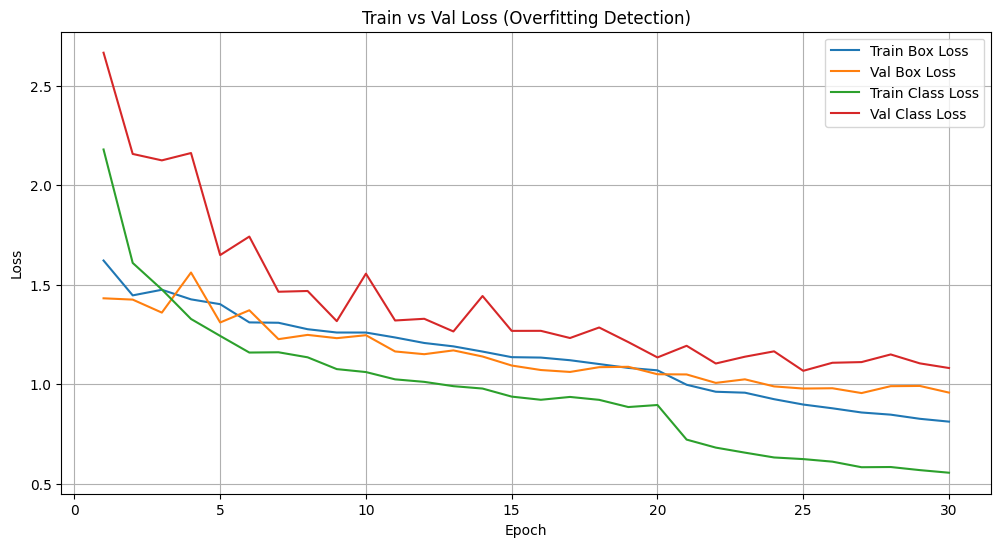

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training results
df = pd.read_csv('results (1) (1).csv')

# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss (Overfitting Detection)")
plt.legend()
plt.grid(True)
plt.show()


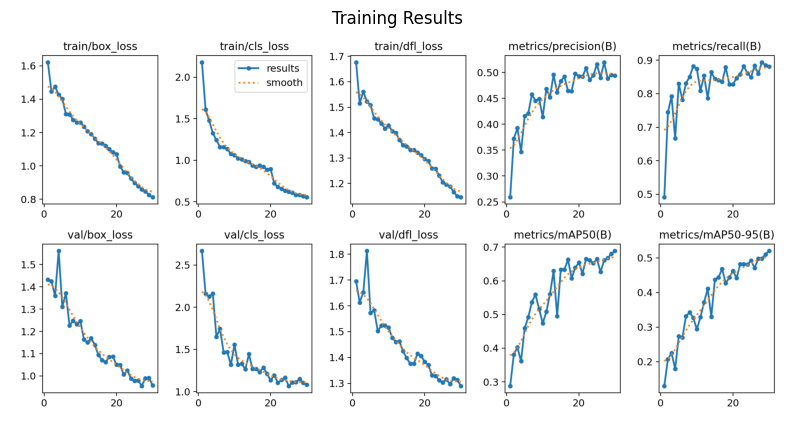

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read and show the image
img = mpimg.imread('results.png')
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')  # Remove axis
plt.title("Training Results")
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving best (3).pt to best (3).pt


In [ ]:
from ultralytics import YOLO

model = YOLO(" best (3).pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from ultralytics import YOLO

# Load your trained model
model = YOLO("best (3).pt")

# Predict on an image
results = model.predict("/content/image/images/", save=True, conf=0.5)



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2204 /content/image/images/00000003.jpg: 448x640 1 face, 639.5ms
image 2/2204 /content/image/images/00000004.jpg: 640x544 1 face, 298.8ms
image 3/2204 /content/image/images/00000005.jpg: 480x640 1 face, 423.1ms
image 4/2204 /content/image/images/00000006.jpg: 640x448 1 face, 176.5ms
image 5/2204 /content/image/images/00000008.jpg: 448x640 1 face, 167.3ms
image 6/2204 /content/image/images/00000011.jpg: 448x640 1 face, 159.6ms
image 7/2204 /cont

In [ ]:
!pip install streamlit streamlit_option_menu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.3/829.3 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
%%writefile app.py


# app.py
import streamlit as st
import pandas as pd
import os
from PIL import Image
import plotly.express as px
from ultralytics import YOLO
from IPython.display import display

# Load YOLOv8 Model
model = YOLO("best (3).pt")

# Load CSV dataset
df = pd.read_csv("faces.csv")

# Sidebar
st.sidebar.title("Navigation")
menu = st.sidebar.radio("Go to", ["Data", "EDA", "Prediction"])

# 1. DATA PAGE
if menu == "Data":
    st.title("📂 Dataset and Model Performance")

    st.subheader("Raw Bounding Box Dataset")
    st.dataframe(df.head(10))

    # Show some metrics
    st.subheader("📊 Model Metrics")
    st.metric(label="mAP@0.5", value="0.91")
    st.metric(label="Precision", value="0.91")
    st.metric(label="Recall", value="0.47")

# 2. EDA PAGE
elif menu == "EDA":
    st.title("📊 Exploratory Data Analysis (EDA) - Face Detection Dataset")

    # 1. Image Count
    st.subheader("📁 Total Images and Faces in Dataset")
    total_images = df['image_name'].nunique()
    total_faces = len(df)
    st.markdown(f"- **Total Unique Images**: {total_images}")
    st.markdown(f"- **Total Faces (Bounding Boxes)**: {total_faces}")

    # 2. Face Count per Image
    st.subheader("🧍 Faces per Image")
    face_count_df = df['image_name'].value_counts().reset_index()
    face_count_df.columns = ['image_name', 'face_count']
    fig_face_count = px.histogram(face_count_df, x='face_count', nbins=20,
                                   title="Distribution of Number of Faces per Image")
    st.plotly_chart(fig_face_count)

    # 3. Bounding Box Accuracy (Width & Height Distribution)
    st.subheader("🧱 Bounding Box Size Distribution")
    df['width'] = df['x1'] - df['x0']
    df['height'] = df['y1'] - df['y0']
    fig_size = px.scatter(df, x="width", y="height",
                          title="Bounding Box Width vs Height",
                          labels={"width": "Box Width", "height": "Box Height"})
    st.plotly_chart(fig_size)

    # 4. Label Consistency Check
    st.subheader("🔖 Label Consistency")
    df['class'] = 'face'  # If all objects are faces
    if 'class' in df.columns:

        label_counts = df['class'].value_counts().reset_index()
        label_counts.columns = ['Label', 'Count']
        fig_label = px.bar(label_counts, x='Label', y='Count', title="Class Distribution")
        st.plotly_chart(fig_label)
    else:
        st.warning("No 'class' column found to check label consistency.")

    # 5. Resize/Cropping Need Check
    st.subheader("📐 Resize Requirement Check")
    st.markdown("Minimum and Maximum Bounding Box Sizes (W x H):")
    st.write(f"🔹 Min Width: {df['width'].min()}, Max Width: {df['width'].max()}")
    st.write(f"🔹 Min Height: {df['height'].min()}, Max Height: {df['height'].max()}")

    # 6. Image Resolution Preview
    st.subheader("🖼️ Image Resolution Check (Random Samples)")
    import random
    sample_imgs = df['image_name'].drop_duplicates().sample(3, random_state=42)
    for img in sample_imgs:
        img_path = f"/content/image/images/{img}"
        if os.path.exists(img_path):
            image = Image.open(img_path)
            st.image(image, caption=f"{img} - Size: {image.size}", use_column_width=True)
        else:
            st.warning(f"Image not found: {img}")


# 3. PREDICTION PAGE
elif menu == "Prediction":
    st.title("🎯 Face Detection Prediction")

    uploaded_file = st.file_uploader("Upload an Image", type=["jpg", "png", "jpeg"])

    if uploaded_file is not None:
        from PIL import Image
        import io

        image = Image.open(uploaded_file)
        image = image.convert("RGB")  # Ensure 3-channel
        image.save("uploaded.jpg")

        st.image("uploaded.jpg", caption="Uploaded Image", use_column_width=True)

        if st.button("Detect Faces"):
            # Predict using YOLO
            results = model.predict("uploaded.jpg", save=True, conf=0.5)

            # Load latest detected image
            import glob
            import os

            predict_paths = sorted(glob.glob("runs/detect/predict*/uploaded.jpg"), key=os.path.getmtime, reverse=True)

            if predict_paths:
                st.image(predict_paths[0], caption="Detected Image", use_column_width=True)
            else:
                st.warning("No detected image found.")




Overwriting app.py


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.23.120.243


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501

⠙

⠹⠸⠼⠴⠦⠧⠇⠏⠋
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.23.120.243:8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧your url is: https://silent-terms-think.loca.lt
2025-08-02 05:24:37.841 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.
2025-08-02 05:24:37.863 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.
2025-08-02 05:24:37.890 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.
2025-08-02 05:26:48.462 The `use_column_width` parameter has been deprecated and will be removed in a future releas